In [20]:
import torch.nn as nn
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import time
from torch.autograd import Variable
import matplotlib.pyplot as plt



In [21]:
len_classes = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [22]:
def get_moon_data(n_samples=1000, noise=0.1):

    X, y = make_moons(n_samples=n_samples, noise=noise, random_state=42)

    # Train test split
    X_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    X_train = torch.as_tensor(X_train, dtype=torch.float32, device=device)
    y_train = torch.as_tensor(y_train, dtype=torch.float32, device=device)
    x_test = torch.as_tensor(x_test, dtype=torch.float32, device=device)
    y_test = torch.as_tensor(y_test, dtype=torch.float32, device=device)
    return X_train, y_train, x_test, y_test

In [35]:
class PrepareData(Dataset):

    def __init__(self, X, y):
        self.X = X
        self.y = y
        if not torch.is_tensor(X):
            self.X = torch.from_numpy(X)
        if not torch.is_tensor(y):
            self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

X_train, y_train, X_test, y_test = get_moon_data(n_samples=5000, noise=0.1)

train_dataset = PrepareData(X=X_train, y=y_train)
train_loader = DataLoader(train_dataset, batch_size=X_train.shape[0], shuffle=True)

test_dataset = PrepareData(X=X_test, y=y_test)
test_loader = DataLoader(test_dataset, batch_size=X_test.shape[0], shuffle=True)

In [24]:
#input is 2,500
#activation is relu
#2nd linear 500, 500
#activation is relu
#500, 2
#activation is sigmoid

#train, test and loss plots, epochs = 200


class MyNet(nn.Module):
  def __init__(self, hidden_dims, out_class):
    super().__init__()
    self.layer1 = nn.Linear(2, hidden_dims)
    self.relu = nn.ReLU()
    self.layer2 = nn.Linear(hidden_dims,hidden_dims)
    self.clf = nn.Linear(hidden_dims,out_class)
    self.sig = nn.Sigmoid()

  def forward(self, x):
    x = self.layer1(x)
    x = self.relu(x)
    x = self.layer2(x)
    x = self.relu(x)
    x = self.clf(x)
    x = self.sig(x)

    return x

MyNet(
  (layer1): Linear(in_features=2, out_features=500, bias=True)
  (relu): ReLU()
  (layer2): Linear(in_features=500, out_features=500, bias=True)
  (clf): Linear(in_features=500, out_features=2, bias=True)
  (sig): Sigmoid()
)


In [36]:
def evalModel(net, testloader):
  acc = 0.0
  count = 0
  start_time = time.time()
  device = 'gpu' if next(net.parameters()).is_cuda else 'cpu'
  net.eval()

  for iter, (x, y) in enumerate(testloader):
        count += x.shape[0]
        batch_x = Variable(x).float()
        batch_y = Variable(y).long()
        if device == 'gpu':
          batch_x = batch_x.cuda()
          batch_y = batch_y.cuda()
        outputs = net(batch_x)
        acc += torch.sum(outputs.max(1)[1]==batch_y)

  time_lapse = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))
  print('Accuracy: {:5f} | Time: {}'.format(acc/count,time_lapse))
  return acc/count


In [67]:
def trainModel(net, trainloader, train_option, testloader):
  loss_func = nn.CrossEntropyLoss()
  lr = train_option['lr']
  epoch = train_option['epoch']
  device = train_option['device'] if 'device' in train_option.keys() else 'cpu'
  log_iter = train_option['log_iter'] if 'log_iter' in train_option.keys() else 20
  eval_epoch = 1

  # optimizer = optim.SGD(net.parameters(), lr)
  optimizer = train_option['optim']

  start_time = time.time()
  if device == 'gpu':
    net = net.cuda()

  iters = 0
  running_loss = 0.0

  losses = []
  training_accs = []
  testing_accs = []

  for ep in range(epoch):
    net.train()
    acc = 0.0
    count = 0
    loss = 0
    for iter, (x, y) in enumerate(trainloader):
      iters += 1
      batch_x = Variable(x).float()
      batch_y = Variable(y).long()
      if device == 'gpu':
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()

      outputs = net(batch_x)
      loss = loss_func(outputs, batch_y)

      # print(outputs[0], outputs.max(1)[1][0])

      acc += torch.sum(outputs.max(1)[1]==batch_y)
      count += x.shape[0]

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      loss += loss.item()

      time_lapse = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))
      if iter % log_iter == 0:
        print('Epoch:{:2d} | Iter:{:5d} | Time: {} | Train Loss: {:.4f} | Average Loss: {:.4f} '.format(ep+1, iter, time_lapse, loss.item(), running_loss/iters))

    if testloader is not None and ep % eval_epoch == 0:
      testing_accs.append(evalModel(net, testloader).item())
    else:
      testing_accs.append(0)

    losses.append(loss.item())
    training_accs.append((acc/count).item())

  return losses, training_accs, testing_accs

In [74]:
mynet = MyNet(100, 2)

print(mynet)

MyNet(
  (layer1): Linear(in_features=2, out_features=100, bias=True)
  (relu): ReLU()
  (layer2): Linear(in_features=100, out_features=100, bias=True)
  (clf): Linear(in_features=100, out_features=2, bias=True)
  (sig): Sigmoid()
)


In [75]:
train_option = {}
train_option['lr'] = 0.1
train_option['epoch'] = 200
train_option['device'] = 'cpu'
train_option['optim'] = optim.SGD(mynet.parameters(), 0.1)
losses_sgd, training_accs_sgd, testing_accs_sgd = trainModel(mynet, train_loader, train_option, test_loader)
mynet = MyNet(100, 2)
train_option['optim'] = optim.Adam(mynet.parameters(), 0.1)
losses_adam, training_accs_adam, testing_accs_adam = trainModel(mynet, train_loader, train_option, test_loader)
mynet = MyNet(100, 2)
train_option['optim'] = optim.Adagrad(mynet.parameters(), 0.1)
losses_adagrad, training_accs_adagrad, testing_accs_adagrad = trainModel(mynet, train_loader, train_option, test_loader)

Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 1.3909 | Average Loss: 0.6955 
Accuracy: 0.326667 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:00 | Train Loss: 1.3860 | Average Loss: 0.6942 
Accuracy: 0.467333 | Time: 00:00:00
Epoch: 3 | Iter:    0 | Time: 00:00:00 | Train Loss: 1.3810 | Average Loss: 0.6930 
Accuracy: 0.522667 | Time: 00:00:00
Epoch: 4 | Iter:    0 | Time: 00:00:00 | Train Loss: 1.3761 | Average Loss: 0.6918 
Accuracy: 0.578000 | Time: 00:00:00
Epoch: 5 | Iter:    0 | Time: 00:00:00 | Train Loss: 1.3713 | Average Loss: 0.6905 
Accuracy: 0.631333 | Time: 00:00:00
Epoch: 6 | Iter:    0 | Time: 00:00:00 | Train Loss: 1.3664 | Average Loss: 0.6893 
Accuracy: 0.678667 | Time: 00:00:00
Epoch: 7 | Iter:    0 | Time: 00:00:00 | Train Loss: 1.3616 | Average Loss: 0.6881 
Accuracy: 0.732000 | Time: 00:00:00
Epoch: 8 | Iter:    0 | Time: 00:00:00 | Train Loss: 1.3567 | Average Loss: 0.6869 
Accuracy: 0.761333 | Time: 00:00:00
Epoch: 9 | Iter:    0 | Time: 00:00:01 |

In [39]:
print(testing_accs[0])

0.4866666793823242


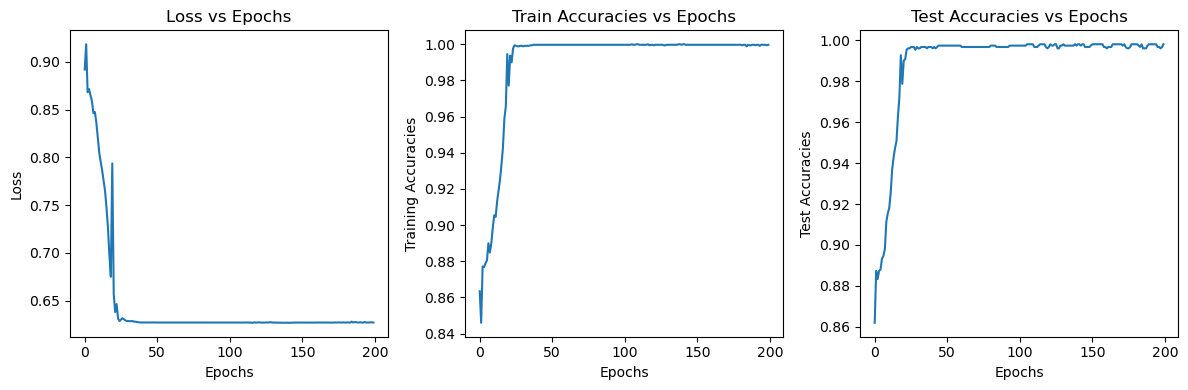

In [55]:
fig, axs = plt.subplots(1,3, figsize= (12,4))

axs[0].plot(range(200), losses)
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_title("Loss vs Epochs")

axs[1].plot(range(200), training_accs)
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Training Accuracies")
axs[1].set_title("Train Accuracies vs Epochs")

axs[2].plot(range(200), testing_accs)
axs[2].set_xlabel("Epochs")
axs[2].set_ylabel("Test Accuracies")
axs[2].set_title("Test Accuracies vs Epochs")

plt.tight_layout()

# ADMM

## Data Loading

In [41]:
def get_moon_data_admm(n_samples=1000, noise=0.1):
    
    X, y = make_moons(n_samples=n_samples, noise=noise, random_state=42)
    
    # Categorical vector
    y_h = np.zeros((len(y), 2))
    for i in range(len_classes):
        class_vec = np.zeros(len_classes)
        class_vec[i] = 1
        y_h[np.where(y==i)] = class_vec
    
    # Train test split
    X_train, x_test, y_train, y_test = train_test_split(X, y_h, test_size=0.3, random_state=42)
    X_train = torch.as_tensor(X_train, dtype=torch.float32, device=device)
    y_train = torch.as_tensor(y_train, dtype=torch.float32, device=device)
    x_test = torch.as_tensor(x_test, dtype=torch.float32, device=device)
    y_test = torch.as_tensor(y_test, dtype=torch.float32, device=device)
    return X_train, y_train, x_test, y_test    
    

## Helpers

In [191]:
import torch
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# return softmax
def cross_entropy_with_softmax(label, zl):
    prob = softmax(zl)
    imask =torch.eq(prob,0.0)
    prob = torch.where(imask,torch.tensor(1e-10,device=device),prob)
    loss = cross_entropy(label, prob)
    return loss
def softmax(x):
    exp =torch.exp(x)
    imask =torch.eq(exp,float("inf"))
    exp = torch.where(imask,torch.exp(torch.tensor(88.6,device=device)),exp)
    return exp/(torch.sum(exp,dim=0)+1e-10)
def cross_entropy(label, prob):
    loss = -torch.sum(label * torch.log(prob))
    return loss
#return the  relu function
def relu(x):
    # return torch.maximum(x, torch.tensor(0,device=device)) + (0.1)*torch.minimum(x, torch.tensor(0, device=device))
    
    tanh = (torch.exp(x)-torch.exp(-x))/(torch.exp(x)+torch.exp(-x))
    tanh = tanh.to(device)
    return tanh

def tanh(x):
    tanh = (torch.exp(x)-torch.exp(-x))/(torch.exp(x)+torch.exp(-x))
    tanh = tanh.to(device)
    return tanh
def leaky_relu(x):
    if(x > 0):
        return x
    else:
        return 0.1 * x
# return phi
def eq1(a, W_next, b_next, z_next, u_next,rho):
    temp = z_next - torch.matmul(W_next, a) - b_next+u_next/rho
    res = rho / 2 * torch.sum(temp * temp)
    return res
# return the derivative of phi with regard to a
def eq1_a(a, W_next, b_next, z_next, u_next,rho):
    res = rho * torch.matmul(torch.transpose(W_next,0,1), torch.matmul(W_next, a) + b_next - z_next-u_next/rho)
    return res
# return the derivative of phi with regard to W
def eq1_W(a, W_next, b_next, z_next, u_next,rho):
    temp = torch.matmul(W_next, a) + b_next - z_next-u_next/rho
    temp2 = torch.transpose(a,0,1)
    res = rho * torch.matmul(temp, temp2)
    return res
# return the derivative of phi with regard to b
def eq1_b(a, W_next, b_next, z_next,u_next, rho):
    res = torch.reshape(torch.mean(rho * (torch.matmul(W_next, a) + b_next - z_next-u_next/rho), dim=1),shape=(-1, 1))
    return res
# return the derivative of phi with regard to z
def eq1_z(a, W_next, b_next, z_next, u_next, rho):
    res = rho * (z_next - b_next - torch.matmul(W_next, a)+u_next/rho)
    return res
# return the quadratic approximation of W-subproblem
def P(W_new, theta, a_last, W, b, z, u,rho):
    temp = W_new - W
    res = eq1(a_last, W, b, z, u,rho) + torch.sum(eq1_W(a_last, W, b, z, u,rho) * temp) + torch.sum(theta * temp * temp) / 2
    return res
# return the quadratic approximation of a-subproblem
def Q(a_new, tau, a, W_next, b_next, z_next, u_next,v,z,rho):
    temp = a_new - a
    res = a_obj(a, W_next, b_next, z_next, u_next,v,z,rho) + torch.sum(a_obj_gradient(a, W_next, b_next, z_next, u_next,v,z,rho) * temp) + torch.sum(
        tau * temp * temp) / 2
    return res
# return the objective value of a-subproblem
def a_obj(a, W_next, b_next, z_next, u_next,v,z,rho):
    res=eq1(a, W_next, b_next, z_next, u_next,rho)+rho/2*torch.sum((a-relu(z)+v)*(a-relu(z)+v))
    return res
# return the gradient of a-subproblem
def a_obj_gradient(a, W_next, b_next, z_next, u_next,v,z,rho):
    res=eq1_a(a, W_next, b_next, z_next, u_next,rho)+rho*(a-relu(z)+v)
    return res
# return the result of W-subproblem
def update_W(a_last, b, z, W_old, u,rho,alpha=1):
    gradients = eq1_W(a_last, W_old, b, z, u,rho)
    gamma = 2
    zeta = W_old - gradients / alpha
    while (eq1(a_last, zeta, b, z, u,rho) > P(zeta, alpha, a_last, W_old, b, z, u,rho)):
        alpha = alpha * gamma
        zeta = W_old - gradients / alpha  # Learning rate decreases to 0, leading to infinity loop here.
    theta = alpha
    W = zeta
    return W
# return the result of b-subproblem
def update_b(a_last, W, z, b_old, u,rho):
    gradients = eq1_b(a_last, W, b_old, z, u,rho)
    res = b_old - gradients / rho
    return res
# return the objective value of z-subproblem
def z_obj(a_last, W, b, z, u,v,a,rho):
    f=(z-torch.matmul(W,a_last)-b+u/rho)*(z-torch.matmul(W,a_last)-b+u/rho)+(a-relu(z)+v)*(a-relu(z)+v)
    return f
# return the result of z-subproblem
def update_z(a_last, W, b, a, u,v,rho):
    z1=torch.matmul(W,a_last)+b-u/rho;
    z2=(z1+a+v)/2
    z1=torch.minimum(z1,torch.tensor(0))
    z2=torch.maximum(z2,torch.tensor(0))
    value1=z_obj(a_last, W, b, z1, u,v,a,rho)
    value2=z_obj(a_last, W, b, z2, u,v,a,rho)
    imask =torch.greater(value1,value2)
    z=torch.where(imask,z2,z1)
    return z
# return the result of z_L-subproblem by FISTA
def update_zl(a_last, W, b, label, zl_old, u,rho):
    fzl = 10e10
    MAX_ITER = 500
    zl = zl_old
    lamda = 1
    zeta = zl
    eta = 4
    TOLERANCE = 1e-3
    for i in range(MAX_ITER):
        fzl_old = fzl
        fzl = cross_entropy_with_softmax(label, zl)+rho/2*torch.sum((zl-torch.matmul(W,a_last)-b+u/rho)*(zl-torch.matmul(W,a_last)-b+u/rho))
        if abs(fzl - fzl_old) < TOLERANCE:
            break
        lamda_old = lamda
        lamda = (1 + np.sqrt(1 + 4 * lamda * lamda)) / 2
        gamma = (1 - lamda_old) / lamda
        gradients2 = (softmax(zl) - label)
        zeta_old = zeta
        zeta = (rho * (torch.matmul(W, a_last)+b-u/rho) + (zl - eta * gradients2) / eta) / (rho + 1 / eta)
        zl = (1 - gamma) * zeta + gamma * zeta_old
    return zl
# return the result of a-subproblem
def update_a(W_next, b_next, z_next, z, a_old, u_next,v,rho,t=1):
    gradient = a_obj_gradient(a_old, W_next, b_next, z_next, u_next, v,z,rho)
    eta = 2
    beta=a_old-gradient/t
    while (a_obj(beta, W_next, b_next, z_next, u_next,v,z,rho) > Q(beta, t, a_old, W_next, b_next, z_next, u_next,v,z,rho)):
        t = t * eta
        beta =a_old-gradient/t
    tau = t
    a = beta
    return a

## Metric

In [179]:
def get_accuracy(W, b, X, y):
    nums = y.shape[1]
    z = []
    a = []
    for i in range(len(W)):
        if(i == 0):
            z.append(torch.matmul(W[i], X) + b[i])
        else:
            a.append(relu(z[-1]))
            z.append(torch.matmul(W[i], a[i-1]) + b[i])
    
    cost = cross_entropy_with_softmax(y, z[-1]) / nums
    actual = torch.argmax(y, dim=0)
    pred = torch.argmax(z[-1], dim=0)
    return (torch.sum(torch.eq(pred, actual)) / nums, cost)    


# return the value of the augmented Lagrangian
def objective(x_train, y_train, W, b, z, a, u, rho):
    r = []
    for i in range(len(W)):
        if(i==0):
            r.append(torch.sum((z[i] - torch.matmul(W[i], x_train) - b[i]) * (z[i] - torch.matmul(W[i], x_train) - b[i])))
        else:
            r.append(torch.sum((z[i] - torch.matmul(W[i], a[i-1]) - b[i]) * (z[i] - torch.matmul(W[i], a[i-1]) - b[i])))
    
    loss = cross_entropy_with_softmax(y_train, z[-1])
    
    obj = loss + torch.trace(torch.matmul(z[-1] - torch.matmul(W[-1], a[-1]) - b[-1], torch.transpose(u,0,1)))
    
    for i in range(len(r)):
        obj = obj + (rho/2)*r[i]
    cum = 0
    for i in range(len(a)):
        obj = obj + (rho/2)*torch.sum((a[i] - relu(z[i])) * (a[i] - relu(z[i])))
    return obj, loss

## Model

In [192]:
class ADMMNet():

    def __init__(self, params):
       
        seed_num = 18
        torch.random.manual_seed(seed=seed_num)
        
        hidden_layers = params['layers']
        self.W = []
        self.b = []
        self.z = []
        self.a = []
        self.u = None
        self.n_layers = len(hidden_layers)
        
        self.train_acc = [0]
        self.test_acc = [0]
        self.train_cost = []
        self.test_cost = []
        self.objective_value = []
        
        for layer in hidden_layers:
            torch.random.manual_seed(seed=seed_num)
            self.W.append(torch.normal(size=layer, mean=0, std=0.1, device=device))
            torch.random.manual_seed(seed=seed_num)
            self.b.append(torch.normal(size=(layer[0], 1), mean=0, std=0.1, device=device))
        
    def initialize(self, x_train, label):
        for i in range(self.n_layers):
            if(i == self.n_layers-1):
                imask = torch.eq(label, 0)
                self.z.append(torch.where(imask, -torch.ones_like(label), torch.ones_like(label)))
            elif(i==0):             
                self.z.append(torch.matmul(self.W[i], x_train) + self.b[i])
                self.a.append(relu(self.z[-1]))
            else:
                self.z.append(torch.matmul(self.W[i], self.a[i-1]) + self.b[i])
                self.a.append(relu(self.z[-1]))

        self.u = torch.zeros(self.z[-1].shape, device=device)    
    
    
    def fit(self, hyper_params, x_train, y_train):
        
       
        
        ## Params
        rho = hyper_params["rho"]
        theta = hyper_params["theta"]
        tau = hyper_params["tau"]        
        num_iter = hyper_params["num_iter"]
        
        linear_r = np.ones(num_iter)
        self.objective_value = np.ones(num_iter)
        self.train_acc = np.zeros(num_iter+1)
        self.train_cost = np.ones(num_iter+1)
        self.test_acc = np.zeros(num_iter+1)
        self.test_cost = np.ones(num_iter)
        ## Backward
        (_, self.train_cost[0]) = get_accuracy(self.W, self.b, x_train, y_train)
        
        for j in range(num_iter):
            pre = time.time()
            for i in range(self.n_layers-1, -1, -1):
                if(i!=0):
                    if(i==self.n_layers-1):
                        self.z[i] = update_zl(self.a[i-1], self.W[i], self.b[i], y_train, self.z[i], self.u, rho)
                        self.b[i] = update_b(self.a[i-1], self.W[i], self.z[i], self.b[i], self.u, rho)
                        self.W[i] = update_W(self.a[i-1], self.b[i], self.z[i], self.W[i], self.u, rho, theta)
                        self.a[i-1] = update_a(self.W[i], self.b[i], self.z[i], self.z[i-1], self.a[i-1], self.u, 0, rho, tau)
                    else:
                        self.z[i] = update_z(self.a[i-1], self.W[i], self.b[i], self.a[i], 0, 0, rho)
                        self.b[i] = update_b(self.a[i-1], self.W[i], self.z[i], self.b[i], 0, rho)
                        self.W[i] = update_W(self.a[i-1], self.b[i], self.z[i], self.W[i], 0, rho, theta)
                        self.a[i-1] = update_a(self.W[i], self.b[i], self.z[i], self.z[i-1], self.a[i-1], 0, 0, rho, tau)

                else:
                    self.z[i] = update_z(x_train, self.W[i], self.b[i], self.a[i], 0, 0, rho)
                    self.b[i] = update_b(x_train, self.W[i], self.z[i], self.b[i], 0, rho)
                    self.W[i] = update_W(x_train, self.b[i], self.z[i], self.W[i], 0, rho, theta)
            
            ## Forward
            for i in range(self.n_layers):
                if(i==0):
                    self.W[i] = update_W(x_train, self.b[i], self.z[i], self.W[i], 0, rho, theta)
                    self.b[i] = update_b(x_train, self.W[i], self.z[i], self.b[i], 0, rho)
                    self.z[i] = update_z(x_train, self.W[i], self.b[i], self.a[i], 0, 0, rho)
                    self.a[i] = update_a(self.W[i+1], self.b[i+1], self.z[i+1], self.z[i], self.a[i], 0, 0, rho, tau)
                elif(i==self.n_layers-1):
                    self.W[i] = update_W(self.a[i-1], self.b[i], self.z[i], self.W[i], self.u, rho, theta)
                    self.b[i] = update_b(self.a[i-1], self.W[i], self.z[i], self.b[i], self.u, rho)
                    self.z[i] = update_zl(self.a[i-1], self.W[i], self.b[i], y_train, self.z[i], self.u, rho)
                else:
                    self.W[i] = update_W(self.a[i-1], self.b[i], self.z[i], self.W[i], 0, rho, theta)
                    self.b[i] = update_b(self.a[i-1], self.W[i], self.z[i], self.b[i], 0, rho)
                    self.z[i] = update_z(self.a[i-1], self.W[i], self.b[i], self.a[i], 0, 0, rho)
                    self.a[i] = update_a(self.W[i+1], self.b[i+1], self.z[i+1], self.z[i], self.a[i], self.u, 0, rho, tau)
                    

            self.u = self.u + rho * (self.z[-1] - torch.matmul(self.W[-1], self.a[-1]) - self.b[-1])
            r = []
            for i in range(self.n_layers):
                if(i == 0):
                    r.append(torch.sum((self.z[i] - torch.matmul(self.W[i], x_train) - self.b[i]) * (self.z[i] - torch.matmul(self.W[i], x_train) - self.b[i])))
                else:
                    r.append(torch.sum((self.z[i] - torch.matmul( self.W[i], self.a[i-1]) - self.b[i]) * (self.z[i] - torch.matmul(self.W[i], self.a[i-1]) - self.b[i])))

            linear_r[j] = r[-1]

            obj, loss = objective(x_train, y_train, self.W, self.b, self.z, self.a, self.u, rho)
            self.objective_value[j] = obj.cpu().numpy()
            (self.train_acc[j+1], self.train_cost[j+1]) = get_accuracy(self.W, self.b, x_train, y_train)
            (self.test_acc[j+1], self.test_cost[j]) = get_accuracy(self.W, self.b, x_test, y_test)
            
            print("Epoch: {} | Lagrangian Objective: {:.2f} | Train Loss: {:.2f} | Test loss: {:.2f} | Train accuracy: {:.2f} | Test Accuracy: {:.2f}".format(
                j+1, obj, self.train_cost[j], self.test_cost[j], self.train_acc[j], self.test_acc[j]
            ))
            print("=====================================================================================================================")
                
        
            
            
        

In [181]:
X_train, y_train, x_test, y_test = get_moon_data_admm(n_samples=5000, noise=0.1)
X_train =torch.transpose(X_train, 0, 1)
y_train = torch.transpose(y_train, 0, 1)
x_test = torch.transpose(x_test, 0, 1)
y_test = torch.transpose(y_test, 0, 1)

In [193]:
params = {
    "layers" : [(100, 2), (100, 100), (2, 100)],
}
net = ADMMNet(params)
net.initialize(X_train, y_train)
hyper_params = {
    'rho' : 1e-06,
    'tau' : 1e-03,
    'theta' : 1e-03,
    'num_iter': 200
}
net.fit(hyper_params, X_train, y_train)


Epoch: 1 | Lagrangian Objective: 0.22 | Train Loss: 0.89 | Test loss: 0.48 | Train accuracy: 0.00 | Test Accuracy: 0.00
Epoch: 2 | Lagrangian Objective: 0.20 | Train Loss: 0.52 | Test loss: 0.49 | Train accuracy: 0.80 | Test Accuracy: 0.82
Epoch: 3 | Lagrangian Objective: 0.15 | Train Loss: 0.52 | Test loss: 0.57 | Train accuracy: 0.84 | Test Accuracy: 0.85
Epoch: 4 | Lagrangian Objective: 0.08 | Train Loss: 0.60 | Test loss: 0.40 | Train accuracy: 0.87 | Test Accuracy: 0.88
Epoch: 5 | Lagrangian Objective: 0.09 | Train Loss: 0.43 | Test loss: 0.38 | Train accuracy: 0.85 | Test Accuracy: 0.86
Epoch: 6 | Lagrangian Objective: 0.10 | Train Loss: 0.41 | Test loss: 0.33 | Train accuracy: 0.85 | Test Accuracy: 0.86
Epoch: 7 | Lagrangian Objective: 0.10 | Train Loss: 0.36 | Test loss: 0.31 | Train accuracy: 0.87 | Test Accuracy: 0.88
Epoch: 8 | Lagrangian Objective: 0.10 | Train Loss: 0.34 | Test loss: 0.33 | Train accuracy: 0.87 | Test Accuracy: 0.89
Epoch: 9 | Lagrangian Objective: 0.10 | 

In [190]:
net.train_cost[0]
a1 = net.train_acc
a2 = net.test_acc
a3 = net.train_cost

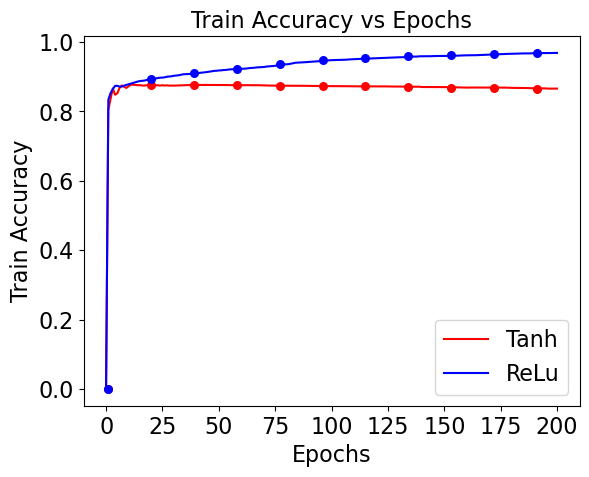

In [195]:
plt.plot(net.train_acc, 'r', label = 'Tanh')
plt.scatter(np.arange(1, 201, 19), net.train_acc[::20], c='r', s=30)

plt.plot(a1, 'b', label='ReLu')
plt.scatter(np.arange(1, 201, 19), np.array(a1[::20]), c='b', s=30)

plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Test Accuracy', fontsize=16)
plt.title('Test Accuracy vs Epochs', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)

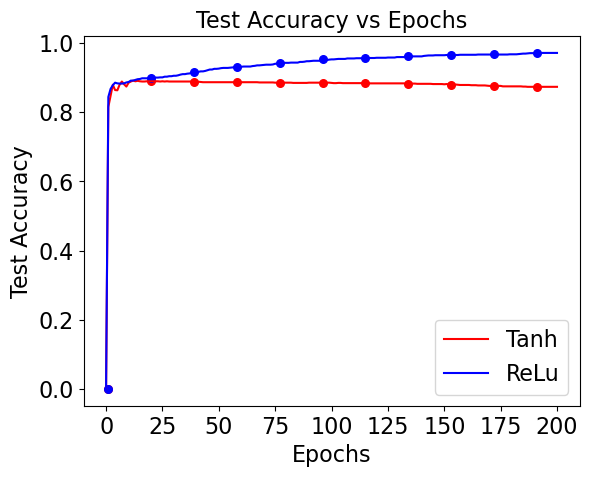

In [198]:
plt.plot(net.test_acc, 'r', label = 'Tanh')
plt.scatter(np.arange(1, 201, 19), net.test_acc[::20], c='r', s=30)

plt.plot(a2, 'b', label='ReLu')
plt.scatter(np.arange(1, 201, 19), np.array(a2[::20]), c='b', s=30)

plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Test Accuracy', fontsize=16)
plt.title('Test Accuracy vs Epochs', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)

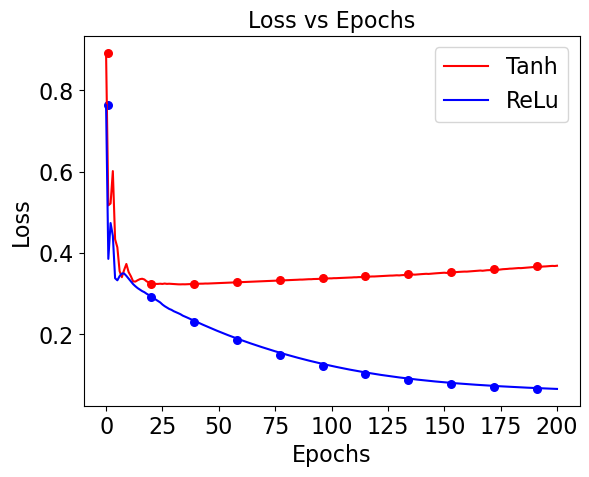

In [200]:
plt.plot(net.train_cost, 'r', label = 'Tanh')
plt.scatter(np.arange(1, 201, 19), net.train_cost[::20], c='r', s=30)

plt.plot(a3, 'b', label='ReLu')
plt.scatter(np.arange(1, 201, 19), np.array(a3[::20]), c='b', s=30)

plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Loss vs Epochs', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)

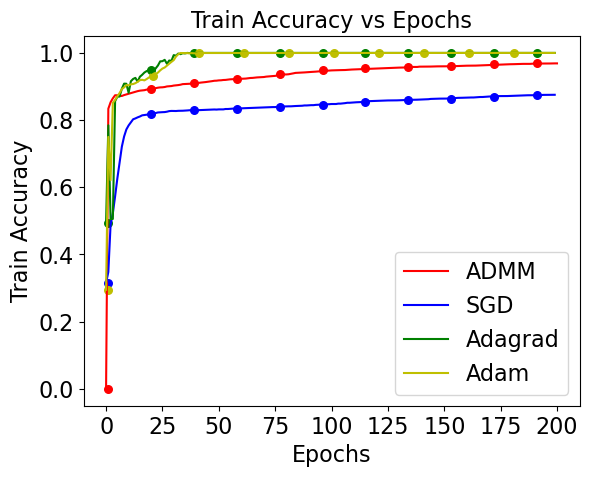

In [189]:
plt.plot(net.train_acc, 'r', label = 'ADMM')
plt.scatter(np.arange(1, 201, 19), net.train_acc[::20], c='r', s=30)

plt.plot(training_accs_sgd, 'b', label='SGD')
plt.scatter(np.arange(1, 201, 19), np.array(training_accs_sgd[::19]), c='b', s=30)

plt.plot(training_accs_adagrad, 'g', label='Adagrad')
plt.scatter(np.arange(1, 201, 19), np.array(training_accs_adagrad[::19]), c='g', s=30)

plt.plot(training_accs_adam, 'y', label='Adam')
plt.scatter(np.arange(1, 201, 20), np.array(training_accs_adam[::20]), c='y', s=30)

plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Train Accuracy', fontsize=16)
plt.title('Train Accuracy vs Epochs', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)

In [152]:
xx = np.arange(1, 201, 19)
print(xx.shape)
print(len(np.array(losses_sgd[::19])))
print(type(net.train_cost[::20]))

(11,)
11
<class 'numpy.ndarray'>


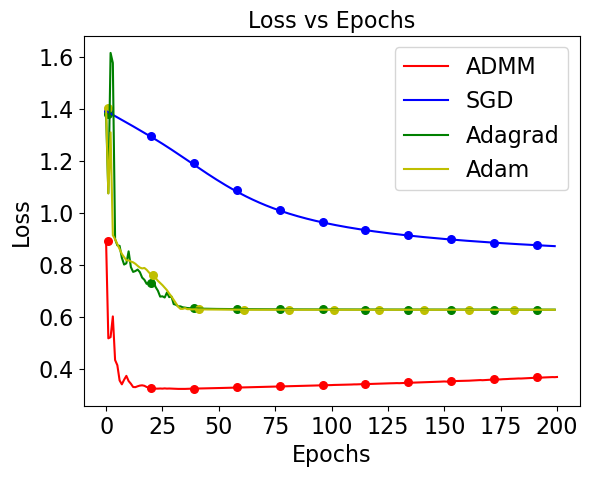

In [185]:
plt.plot(net.train_cost, 'r', label = 'ADMM')
plt.scatter(np.arange(1, 201, 19), net.train_cost[::20], c='r', s=30)
plt.plot(losses_sgd, 'b', label='SGD')
plt.scatter(np.arange(1, 201, 19), np.array(losses_sgd[::19]), c='b', s=30)
plt.plot(losses_adagrad, 'g', label='Adagrad')
plt.scatter(np.arange(1, 201, 19), np.array(losses_adagrad[::19]), c='g', s=30)
plt.plot(losses_adam, 'y', label='Adam')
plt.scatter(np.arange(1, 201, 20), np.array(losses_adam[::20]), c='y', s=30)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Loss vs Epochs', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)

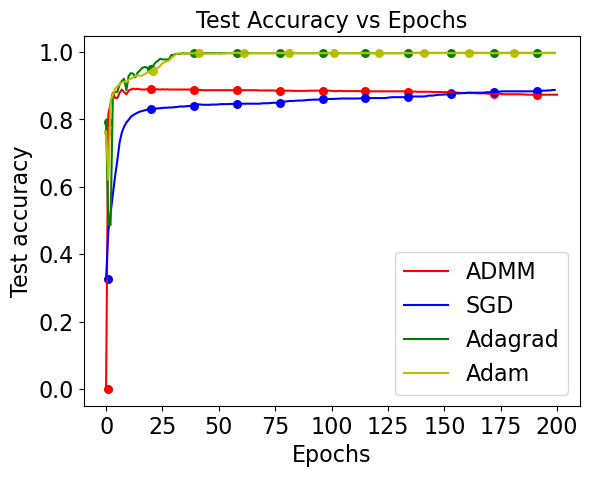

In [186]:
plt.plot(net.test_acc, 'r', label = 'ADMM')
plt.scatter(np.arange(1, 201, 19), net.test_acc[::20], c='r', s=30)
plt.plot(testing_accs_sgd, 'b', label='SGD')
plt.scatter(np.arange(1, 201, 19), np.array(testing_accs_sgd[::19]), c='b', s=30)

plt.plot(testing_accs_adagrad, 'g', label='Adagrad')
plt.scatter(np.arange(1, 201, 19), np.array(testing_accs_adagrad[::19]), c='g', s=30)

plt.plot(testing_accs_adam, 'y', label='Adam')
plt.scatter(np.arange(1, 201, 20), np.array(testing_accs_adam[::20]), c='y', s=30)

plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Test accuracy', fontsize=16)
plt.title('Test Accuracy vs Epochs', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)

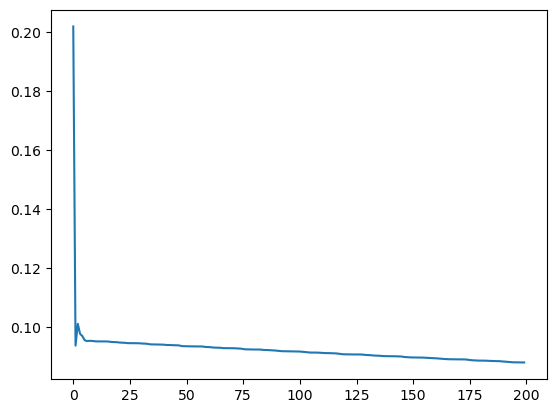

In [116]:
plt.plot(net.objective_value)